# Quantum PCA for Financial Dataset
### **Learning Objectives**
1. Why use Principal Component Analysis (PCA)? How to use PCA?
2. Apply PCA to a dataset. Form statistical conclusions per results.
3. Understand and mitigate the impact of outliers and noisy data.
3. Why use Quantum Annealing (QA)? How to use QA?
4. Experiment with implementing a QA algorithm.

#### **Principal Component Analysis**
*Principal Component Analysis* (PCA) is a common data science procedure used for extracting key features (aka principal components) from a dataset. Knowing the principal components is helpful for dimensionality reduction, denoising, and visualization.  
For an intuitive understanding of PCA, here is a [great rundown from IBM](https://www.ibm.com/think/topics/principal-component-analysis) and youtube has a plethora of instructive videos. Develop an understanding of the fundamentals before continuing.  
Understand both the recursive formulation of PCA and the implementation that solves for several principal components simultaneously.  

### **Quantum Annealing**
*Quantum Annealing* (QA) is an optimization algorithm for finding the global minimum of a solution set. It works by creating quantum fluctations in input data to explore the dataset.  
For an intuitive understanding of QA, there are also some youtube videos that have great visualizers. Here is a [great video](https://youtu.be/zvfkXjzzYOo?si=t1X2Nl-277pAQDV4) from D-Wave.

### **QaPCA**
*Quantum Annealing for Robust Principal Component Analysis* ([pdf](https://arxiv.org/pdf/2501.10431)), published in December 2024, introduced an implementation of PCA using Quantum Annealing. The goal of the article was to develop a *robust* implementation, i.e. an implementation that mitigated the impact of noise.  

### **Problem Statement - Detecting and Analyzing Financial Principal Components with QAPCA**
This challenge will have competitors build L1-PCA classically, followed by QAPCA-R, in order to visualize the natural groupings of different tickers into sectors from price movements. Competitors will be tested on how robustly their implementation manages noise from both the quantum system and the data itself.
##### Input: Time series of stock prices
Steps:
1. Pre-process data
2. Apply PCA classically. 
3. Analyze results.
4. Construct Ising Model for Recursive QaPCA.
5. Analyze results. How do they compare with classical PCA?
6. Bonus.

## Step 0: Downloading data
We will be utilizing stock price data from 2018/01/01 to 2018/03/01 for various different tickers from different sectors. The list of tickers and their corresponding sector are listed as follows:
| Ticker | Company Name           | Sector         |
|--------|------------------------|----------------|
| AAPL   | Apple Inc.             | Technology     |
| AMZN   | Amazon.com Inc.        | Technology     |
| GOOG   | Alphabet Inc Class C   | Technology     |
| MSFT   | Microsoft Corporation  | Technology     |
| XOM    | Exxon Mobil Corp       | Energy         |
| GLD    | SPDR Gold Trust        | Finance        |
| AEP    | Amer. Elec. Power Comp | Utility        |
| DUK    | Duke Energy Corp       | Utility        |
| SO     | Southern Co            | Utility        |

In [1]:
# Handle imports
import pandas as pd
import yfinance as yf
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import functools

In [2]:
tickers_path = 'data/prices.csv'
if os.path.exists(tickers_path):
    print("Loading data from local CSV file.")
    ticker_data = pd.read_csv(tickers_path)
else:
    tickers = ['GOOG', 'XOM', 'AAPL', 'AMZN', 'GLD', 'DUK', 'SO', 'AEP']
    date_range = ['2017-01-01', '2017-03-01']

    ticker_data = yf.download(
        tickers,
        start=date_range[0],
        end=date_range[1],
        group_by="ticker",
        auto_adjust=True
    )
    ticker_data = ticker_data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()

    ticker_data.to_csv(tickers_path, index=False)
    
def create_scatterplot(embeddings, labels, title):
    """
    Create a scatterplot with different color for each label.
    
    Parameters:
    -----------
    embeddings : numpy.ndarray
        Array of shape (2, n_samples) containing 2D embeddings
    labels : list
        List of labels for each sample
    title : str
        Title for the plot
    """
    plt.figure(figsize=(12, 10))
    unique_labels = set(labels)
    colors = sns.color_palette("bright", len(unique_labels))
    
    for color, label in zip(colors, unique_labels):
        idx = [i for i, l in enumerate(labels) if l == label]
        # if embeddings has shape (2, n), we can index directly
        if embeddings.shape[0] == 2:
            x = embeddings[0, idx]
            y = embeddings[1, idx]
        elif embeddings.shape[1] == 2:
            x = embeddings[idx, 0]
            y = embeddings[idx, 1]
        elif embeddings.shape[0] == 1:
            x = embeddings[0, idx]
            y= 0
        elif embeddings.shape[1] == 1:
            x = embeddings[idx, 0]
            y = 0
        else:
            raise ValueError(f'{embeddings.shape} is weird')
        
        plt.scatter(x,y ,
                   color=color, label=label, s=100, alpha=0.6)
        
        # Add text annotations for each point
        for i in idx:
            plt.text(x + 0.0001, y, label, 
                    fontsize=9, alpha=0.7)
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel("PCA Component 1", fontsize=12)
    
    plt.ylabel("PCA Component 2", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

Loading data from local CSV file.


## Step 1: Preparing data
For each ticker, we will look at their daily log returns over the period 2018/01/01 to 2018/03/01. We will treat this list of returns as each ticker's "feature", which acts as a descriptor for the ticker. Compute the daily difference between log returns for each ticker over the provided time period.

In [3]:
# code
tickers = ticker_data['Ticker'].unique().tolist()

# Calculate the daily returns for each ticker by pt/pt-1 - 1
ticker_data = ticker_data.sort_values(by=['Ticker', 'Date'])
ticker_data["Return"] = ticker_data.groupby('Ticker')['Close'].pct_change()
ticker_data['Return'] = ticker_data['Return'].fillna(0)
ticker_data['LogReturn'] = np.log1p(ticker_data['Return'])

# For each ticker, get the vector of LogReturns
log_return_vectors = ticker_data.groupby('Ticker')['LogReturn'].apply(np.array)

# Remove the zero returns
log_return_vectors = log_return_vectors.apply(lambda x: x[x != 0])
log_return_vectors




Ticker
AAPL    [-0.0011199028902573013, 0.00507214869159839, ...
AEP     [0.0014331568900181704, 0.005394855084582408, ...
AMZN    [0.00464647301631583, 0.030269616426223996, 0....
DUK     [-0.001029763606802401, 0.0012867048462190133,...
GLD     [0.0035241475629946054, 0.015395946803090798, ...
GOOG    [0.0009665000493054286, 0.009007379345297757, ...
SO      [-0.0010201691831062953, 0.0030571665019612877...
XOM     [-0.011063485130485693, -0.015019433359217812,...
Name: LogReturn, dtype: object

## Step 2: Apply PCA classically
We will now apply PCA classically on our set of features. Per section 2.2 from the QAPCA paper (linked above), L1-PCA can be defined as the following problem:
$$
    \mathbf{\hat{R}}_{L_1} = \underset{\mathbf{R} \in \mathbb{R}^{D \times K}, \mathbf{R}^T\mathbf{R=I}_K}{\operatorname{\argmax}} ||\mathbf{R}^T\mathbf{X}||_1
$$
where $||*||_1$ is the L1-norm of a vector (sum of absolute entries).  
The paper walks through how to transform this into the binary optimization problem
$$
\mathbf{\hat{R}}_{L_1} = \Phi\left(\mathbf{X}\mathbf{B_{opt}} \right)
$$
where
$$
\mathbf{B_{opt}} = \underset{\mathbf{B} \in \{\pm 1\}^{N \times K}}{\operatorname{\argmax}}\sum_{k=1}^K {\sigma}_k \left[\mathbf{B}^T \mathbf{X}^T \mathbf{XB} \right]
$$
Per the paper, $K$ is the number of PCA components, ${\sigma}_k[*]$ represents the $k^{th}$ singular-value of its argument (derived from SVD), $\mathbf{B} \in \{ \pm 1\}^{N \times K}$ is a binary matrix, and $\Phi(*)$ returns the nearest orthonormal matrix to its argument (solved using SVD).  
For $K = 1$, this expression becomes
$$
\mathbf{B_{opt}} = \underset{\mathbf{B} \in \{\pm 1\}^N}{\operatorname{\argmax}} ||\mathbf{X} \hat{\mathbf{b}}||_2 = \underset{\mathbf{B} \in \{\pm 1\}^N}{\operatorname{\argmax}} \: \hat{\mathbf{b}}^T \mathbf{X}^T\mathbf{X} \hat{\mathbf{b}} 
$$
This binary quadratic form is formally an [NP-hard problem](https://arxiv.org/abs/2301.06978)!!! These are magic words for quantum nerds. We can then rewrite this formulation in Ising form as:
$$
\mathbf{b_{opt}} = \underset{\hat{\mathbf{b}}\in\{\pm 1\}^N}{\operatorname{\argmin}} \hspace{2mm} \hat{\mathbf{b}}^T\left( - \mathbf{X}^T\mathbf{X} \right)\hat{\mathbf{b}} = \underset{\hat{\mathbf{b}}\in\{\pm 1\}^N}{\operatorname{\argmin}} \hspace{2mm} \hat{\mathbf{b}}^T(-\mathbf{J})\hat{\mathbf{b}}
$$
where $J$ represents the covariance matrix.  

We can iteratively anneal and update the covariance matrix to solve for one principal component at a time.  
We offer functions and descriptions, as well as the steps for calling. We recommend implementing helper functions yourself instead of using packages. At one step you should use some optimizer package, e.g. dual_annealing from scipy.optimize.

In [4]:
from scipy.optimize import dual_annealing

def solve_covariance_matrix(sample_data):
    """Calculate covariance matrix for given sample data"""
    
    # For each ticker, get the vector of LogReturns and stack them into a 2D array (features x samples)
    stacked_data = np.vstack(sample_data.values)
    print("Stacked data shape:", stacked_data.shape)  # Debugging line to check shape
    return stacked_data @ stacked_data.T, stacked_data.T


def l1_objective(b, J):
    """
    Compute the L1 PCA objective function.

    Parameters:
    -----------
    b : numpy.ndarray
        The current component vector (will be reshaped to column vector)
    J : numpy.ndarray
        The covariance matrix or modified covariance matrix for the optimization
        
    Returns:
    --------
    float
        The l1 objective function value
    """
    
    # bT(-J)b
    return b.T @ (-J) @ b

def Phi(T):
    # T: (D,K). If K=1 this reduces to unit-normalizing the vector.
    U, _, Vt = np.linalg.svd(T, full_matrices=False)
    return U @ Vt

def solve_l1_classical_component(J):
    """
    Solve for a single L1 PCA component using simulated annealing.
    
    This function finds the k-th principal component by optimizing the L1 objective
    function. For k > 0, it ensures orthogonality with previous components by
    modifying the covariance matrix to ignore the subspace spanned by previous
    components.
    
    Parameters:
    -----------
    J : numpy.ndarray
        The covariance matrix (samples x samples)
        
    Returns:
    --------
    tuple
        A tuple containing:
        - numpy.ndarray: The normalized component vector
        - numpy.ndarray: Covariance matrix, now orthogonal to the kth principal component
    """
    n = J.shape[0]
    
    bounds = [(-1, 1) for _ in range(n)]    
    x0 = np.random.uniform(-1, 1, n)
    result = dual_annealing(l1_objective, bounds, args=(J,), x0=x0)
    
    b_opt = result.x
    print("Optimized b (before normalization):", b_opt)
    
    r_norm_sqrd = b_opt.T @ J @ b_opt
    # r_norm_sqrd = 1
    
    bbT = np.outer(b_opt, b_opt)

    print(f"SHapes: J: {J.shape}, bbT: {bbT.shape}, b_opt: {b_opt.shape}")
    J_new = J 
    J_new = J_new - ((2/r_norm_sqrd) * J @ bbT @ J) 
    J_new = J_new + ((J @ bbT @ J @ bbT @ J) / (r_norm_sqrd**2))

    return b_opt, J_new


def do_l1_pca(sample_data, K, get_component_func=solve_l1_classical_component, is_recursive=True):

    J, X = solve_covariance_matrix(sample_data)

    if is_recursive:
        components = []
        for k in range(K):
            r, J = get_component_func(J)
            components.append(r)
        
        Bopt = np.vstack(components).T
    else:
        Bopt, _ = get_component_func(J)
    
    
    print("Bopt shape:", Bopt.shape)
    print("X shape:", X.shape)
    
    X_Bopt = X @ Bopt
    R_L1 = Phi(X_Bopt)
    
    print("R_L1 shape:", R_L1.shape)
    emb = R_L1.T @ X
    
    # Return embeddings and ticker names
    tickers = sample_data.index.tolist()
    
    return emb, tickers


In [5]:
ticker_data = log_return_vectors
pca_embeddings, _ = do_l1_pca(ticker_data, 1, solve_l1_classical_component)
print("PCA Embeddings shape:", pca_embeddings.shape)


Stacked data shape: (8, 38)
Optimized b (before normalization): [ 1. -1.  1. -1. -1.  1. -1. -1.]
SHapes: J: (8, 8), bbT: (8, 8), b_opt: (8,)
Bopt shape: (8, 1)
X shape: (38, 8)
R_L1 shape: (38, 1)
PCA Embeddings shape: (1, 8)


In [6]:
# Get the tickers list
tickers = log_return_vectors.index.tolist()

tickers_partition = (list(), list())
for idx, tick in enumerate(tickers):
    if pca_embeddings[0,idx] >= 0:
        tickers_partition[0].append(tick)
    else:
        tickers_partition[1].append(tick)

# Display the partitioned tickers
print("Partitioned Tickers based on L1 PCA:")
print("Group 1:", tickers_partition[0])
print("Group 2:", tickers_partition[1])


Partitioned Tickers based on L1 PCA:
Group 1: ['AAPL', 'AMZN', 'GOOG']
Group 2: ['AEP', 'DUK', 'GLD', 'SO', 'XOM']


Stacked data shape: (8, 38)
Optimized b (before normalization): [-1.  1. -1.  1.  1. -1.  1.  1.]
SHapes: J: (8, 8), bbT: (8, 8), b_opt: (8,)
Optimized b (before normalization): [ 1.  1.  1.  1.  1.  1.  1. -1.]
SHapes: J: (8, 8), bbT: (8, 8), b_opt: (8,)
Bopt shape: (8, 2)
X shape: (38, 8)
R_L1 shape: (38, 2)
PCA Embeddings shape: (2, 8)


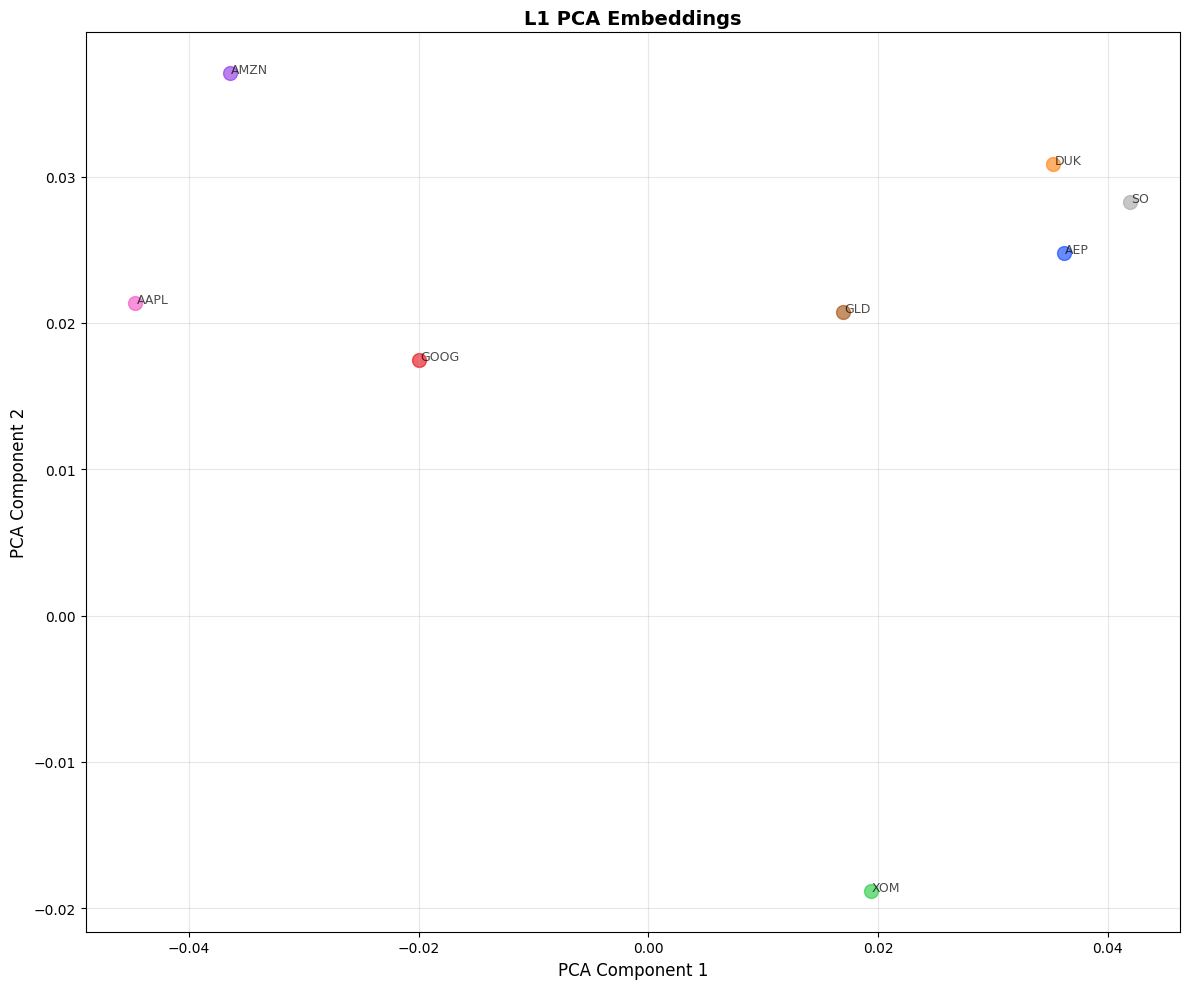

In [7]:
# 2d visualizations
pca_embeddings, _ = do_l1_pca(ticker_data, 2, solve_l1_classical_component)
# Convert (2, N) for scatterplot
# pca_embeddings = pca_embeddings.reshape(2, -1)
print("PCA Embeddings shape:", pca_embeddings.shape)
create_scatterplot(pca_embeddings, tickers, "L1 PCA Embeddings")

## Step 3: Analyze results
After doing PCA on our list of vectors, graph the encodings for each ticker and answer some of the following questions regarding the graph and implementation.
1. Do sectors naturally emerge from the encodings for each ticker? 
2. Why did we need to use PCA to visualize how these sectors emerged?
3. What does it mean for an algorithm to be *robust*? Why is it important for an algorithm to be robust?

#### ***Replace this block with your analysis***
...

## Step 4: Construct Ising Model for QAPCA-R
**Instructions:**  
After completing previous steps, we can now consider how we would run this problem in a format that a quantum computer could read. The model given in Eq. 8 of the paper, which is already included in the description for Step 2 of this prompt, is conveniently already very close to an Ising Model! Read more about Ising Models for an intuitive understanding. The coupling strengths of the Ising model are simply the elements of the covariance matrix $J$.  
We recommend using the package neal's SimulatedAnnealingSampler for solving the Ising Model.

In [8]:
import neal

def convert_J_to_ising_model(X):
    """
    Converts covariance matrix J into dict of Ising Model couplings.
    """
    ising_model = {}
    for i in range(len(X)):
        for j in range(len(X)):
            if i < j:
                ising_model[(i, j)] =  -X[i, j]
    return ising_model

def solve_l1_qapca_r_component(J):
    """
    Solve for a single L1 QAPCA component using simulated annealing.
    
    This function finds the k-th principal component by optimizing the L1 objective
    function. For k > 0, it ensures orthogonality with previous components by
    modifying the covariance matrix to ignore the subspace spanned by previous
    components.
    
    Parameters:
    -----------
    J : numpy.ndarray
        The covariance matrix (samples x samples)
        
    Returns:
    --------
    tuple
        A tuple containing:
        - numpy.ndarray: The normalized component vector
        - numpy.ndarray: Covariance matrix, now orthogonal to the kth principal component
    """
    sampler = neal.SimulatedAnnealingSampler()
    
    h = {i: 0 for i in range(J.shape[0])}
    J_ising = convert_J_to_ising_model(J)
    
    sampleset = sampler.sample_ising(h, J_ising, num_reads=100)
    best_sample = sampleset.first.sample
    
    b_opt = np.array([best_sample[i] for i in range(J.shape[0])])
    r_norm_sqrd = b_opt.T @ J @ b_opt
    bbT = np.outer(b_opt, b_opt)
    
    print(f"SHapes: J: {J.shape}, bbT: {bbT.shape}, b_opt: {b_opt.shape}")
    J_new = J
    J_new = J_new - ((2/r_norm_sqrd) * J @ bbT @ J) 
    J_new = J_new + ((J @ bbT @ J @ bbT @ J) / (r_norm_sqrd**2))   
    
    return b_opt, J_new


In [9]:
qapca_r_embeddings, _ = do_l1_pca(ticker_data, 1, solve_l1_qapca_r_component)

Stacked data shape: (8, 38)
SHapes: J: (8, 8), bbT: (8, 8), b_opt: (8,)
Bopt shape: (8, 1)
X shape: (38, 8)
R_L1 shape: (38, 1)


## Step 5: Analyze results
Analyze your results! Include visuals and brief explanations for what the visuals represent. Also answer some of these questions:  
1. How does Quantum Annealing work?
2. What is an Ising Model?
3. What are key differences between quantum and classical PCA with regards to results and implementation? Are the results guaranteed to be the same?

In [10]:
# code
tickers = log_return_vectors.index.tolist()

tickers_partition = (list(), list())
for idx, tick in enumerate(tickers):
    if qapca_r_embeddings[0, idx] >= 0:
        tickers_partition[0].append(tick)
    else:
        tickers_partition[1].append(tick)

# Display the partitioned tickers
print("Partitioned Tickers based on L1 PCA:")
print("Group 1:", tickers_partition[0])
print("Group 2:", tickers_partition[1])

Partitioned Tickers based on L1 PCA:
Group 1: ['AAPL', 'AMZN', 'GOOG']
Group 2: ['AEP', 'DUK', 'GLD', 'SO', 'XOM']


#### ***Replace with your analysis***
...

## **BONUS:** 
Dig deeper into PCA, QA, and/or QAPCA! With any leftover time, explore alternative implementations and applications. We have listed out some ideas, but explore whatever inspires your team!  
### Ideas:  
1. **Test implementation on bigger dataset!** *Difficulty: 1/5*
2. **Add outliers and test robustness!** *Difficulty: 2/5*
3. **Implement your own annealing algorithm!** *Difficulty: 3/5*
4. **Implement multi-component QAPCA** (section 3.2 of article)**!** *Difficulty: 5/5*
5. **Run this on a quantum computer!** *Difficulty: 5/5*

In [ ]:
# Code
import numpy as np
import neal

def solve_l1_multi_component(J, K=2, eps=0.2, num_reads=100):
    N = J.shape[0]

    # ---- 1. Construct Ising coupling matrix (Eq. 21) ----
    I_K = np.eye(K)
    onesK = np.ones((K, K))

    H = K * np.kron(I_K, -J) - np.kron(onesK - I_K, (-eps) * J)

    J_ising = {}
    for i in range(K * N):
        for j in range(i + 1, K * N):
            val = H[i, j]
            if abs(val) > 1e-12:
                J_ising[(i, j)] = val

    h = {i: 0.0 for i in range(K * N)}  # no biases

    sampler = neal.SimulatedAnnealingSampler()
    sampleset = sampler.sample_ising(h, J_ising, num_reads=num_reads)
    best_sample = sampleset.first.sample

    b_opt = np.array([best_sample[i] for i in range(K * N)])
    B_opt = b_opt.reshape(N,K)

    return B_opt, J

In [26]:
import functools

K = 1
qapca_multi_embeddings, _ = do_l1_pca(ticker_data, K, functools.partial(solve_l1_multi_component, K=K, eps=0.2, num_reads=100), is_recursive=False)

Stacked data shape: (8, 38)
Bopt shape: (8, 1)
X shape: (38, 8)
R_L1 shape: (38, 1)


Stacked data shape: (8, 38)
Bopt shape: (8, 2)
X shape: (38, 8)
R_L1 shape: (38, 2)


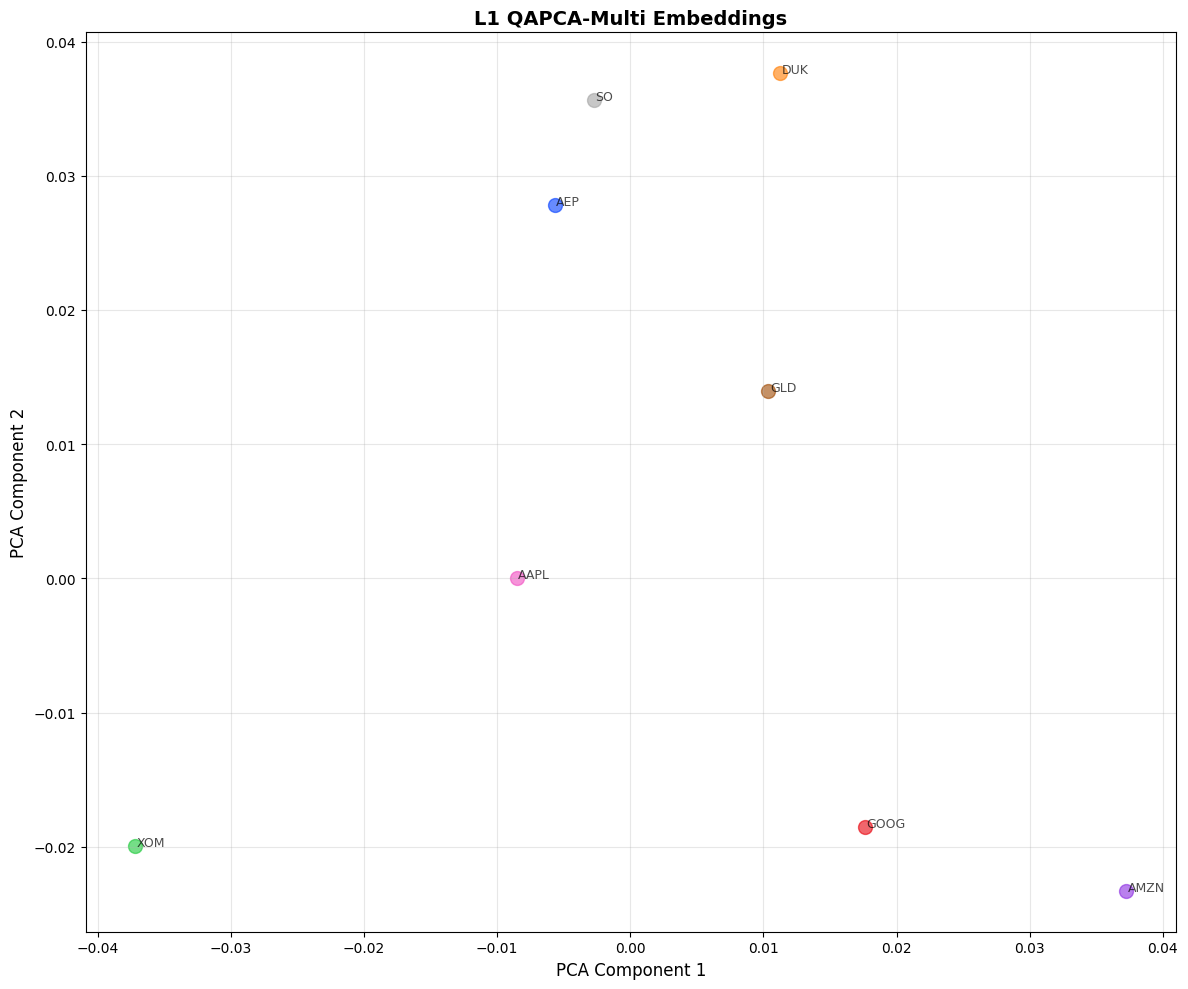

In [29]:
qapca_multi_embeddings_2,_ = do_l1_pca(ticker_data, 2, functools.partial(solve_l1_multi_component, K=2, eps=0.2, num_reads=100), is_recursive=False)

create_scatterplot(qapca_multi_embeddings_2, tickers, "L1 QAPCA-Multi Embeddings")

In [ ]:
# code
tickers = log_return_vectors.index.tolist()

tickers_partition = (list(), list())
for idx, tick in enumerate(tickers):
    if qapca_multi_embeddings[0, idx] >= 0:
        tickers_partition[0].append(tick)
    else:
        tickers_partition[1].append(tick)

# Display the partitioned tickers
print("Partitioned Tickers based on L1 PCA:")
print("Group 1:", tickers_partition[0])
print("Group 2:", tickers_partition[1])

Partitioned Tickers based on L1 PCA:
Group 1: ['AAPL', 'AMZN', 'GOOG']
Group 2: ['AEP', 'DUK', 'GLD', 'SO', 'XOM']


## **Final Step:** Present your findings and pitch your implementation. Why would a financial firm benefit from using your implementation?  
Make sure to submit your presentation on time per QuantathonV2 rules! Understand that we don't care if you use AI, but we do very much care that everyone on your team learns about PCA, QA, and QAPCA!

# End of challenge. Good luck!

<img src="fig2.png" width=400px />

In [43]:
import numpy as np
import neal
import matplotlib.pyplot as plt
import seaborn as sns

def matrix_heatmap(matrix, title="Matrix Heatmap"):
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, fmt=".2f", cmap="viridis", cbar=True)
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Index")
    plt.show()

def compute_kappa_hat(N: int, C_limit: int) -> int:
    """
    Return the largest κ in {0,...,N-1} s.t. 0.5 * (2N - κ) * (κ + 1) ≤ C_limit.
    """
    def bands_count(k):  # counts diagonal + first k-1 superdiagonals
        return 0.5 * (2*N - k) * (k + 1)

    k_hat = 0
    for k in range(N):          # monotone increasing in k for k ≤ N-1
        if bands_count(k) <= C_limit:
            k_hat = k
        else:
            break
    return k_hat

def banded_J_hat(J: np.ndarray, C_limit: int) -> tuple[np.ndarray, int]:
    """
    Build \hat{J} per Eq. (23) using κ̂ from Eq. (24).
    Keeps diagonal at 1/2 J_ii and superdiagonals with 0 < j-i < κ̂.
    """
    N = J.shape[0]

    # kappa_hat = compute_kappa_hat(N, C_limit)
    kappa_hat = 4

    J_hat = np.zeros_like(J)
    # diagonal: 1/2 * J_ii
    # np.fill_diagonal(J_hat, 0.5 * np.diag(J))

    # superdiagonals: 0 < j - i < κ̂  (i.e., j = i+1,...,i+κ̂-1)
    # if kappa_hat > 0:
    #     for i in range(N):
    #         j_max = min(N, i + kappa_hat)   # exclusive upper bound
    #         for j in range(i+1, j_max):
    #             J_hat[i, j] = J[i, j]       # keep only upper-triangular entries
    #             # If your solver expects symmetric J (i<j only is fine for Ising dictionaries),
    #             # you can optionally mirror:
    #             # J_hat[j, i] = J[j, i]
    
    for i in range(N):
        for j in range(N):
            if 0 < j - i < kappa_hat:
                J_hat[i, j] = J[i, j]
            elif i == j:
                J_hat[i, j] = 0.5 * J[i, j]
            

    return J_hat, kappa_hat


def build_J_ising_eq25(J: np.ndarray, K: int, eps: float, C_limit: int):
    """
    Build J_ising (upper-triangular only) according to Eq. (25).
    Global index: q = k*N + i  with k∈[0..K-1], i∈[0..N-1].
    """
    N = J.shape[0]
    # be safe: symmetrize J numerically
    J = 0.5 * (J + J.T)

    kappa_hat = compute_kappa_hat(N, C_limit)
    NK = N * K

    J_ising = {}          # {(q1, q2): weight}, with q1 < q2
    h = {q: 0.0 for q in range(NK)}  # no linear biases from Eq. (25)

    # Helper to insert an upper-triangular entry
    def put(q1, q2, w):
        if abs(w) < 1e-12 or q1 == q2:
            return
        if q1 > q2:
            q1, q2 = q2, q1
        J_ising[(q1, q2)] = J_ising.get((q1, q2), 0.0) + float(w)

    # Loop blocks
    for k1 in range(K):
        for k2 in range(K):
            same = (k1 == k2)
            offdiag_scale = (1.0 if same else -eps)
            diag_scale     = (0.5 if same else -eps/2.0)

            # Diagonal of the (k1,k2) block: only when i==j
            if diag_scale != 0.0:
                for i in range(N):
                    q1 = k1*N + i
                    q2 = k2*N + i
                    if q1 != q2:
                        put(q1, q2, diag_scale * J[i, i])
                    # if q1==q2 (same qubit), Ising linear term would carry it,
                    # but Eq.(25) defines inter-qubit couplers; we leave h=0.

            # Superdiagonal bands: 0 < j - i < kappa_hat
            if kappa_hat > 0 and offdiag_scale != 0.0:
                for i in range(N):
                    jmax = min(N, i + kappa_hat)
                    for j in range(i+1, jmax):
                        w = offdiag_scale * J[i, j]
                        if abs(w) < 1e-12:
                            continue
                        q1 = k1*N + i
                        q2 = k2*N + j
                        put(q1, q2, w)

    return h, J_ising, kappa_hat

def solve_l1_multi_component_embedded(J, K=2, eps=0.2, num_reads=100):
    N = J.shape[0]

    # ---- 1. Construct Ising coupling matrix (Eq. 21) ----
    I_K = np.eye(K)
    onesK = np.ones((K, K))

    matrix_heatmap(J, title="Covariance Matrix J")
    
    # kappa = compute_kappa_hat(N, C_limit=11325)  # Example C_limit
    J_hat, kappa_hat = banded_J_hat(J, C_limit=11325)
    
    matrix_heatmap(J_hat, title=f"Banded Covariance Matrix J_hat (kappa_hat={kappa_hat})")

    h, J_ising, kappa_hat = build_J_ising_eq25(J_hat, K, eps, C_limit=11325)
    
    J_ising_matrix = np.zeros((K*N, K*N))
    for (i, j), val in J_ising.items():
        J_ising_matrix[i, j] = val
        # J_ising_matrix[j, i] = val  # mirror to lower-triangular for visualization

    matrix_heatmap(J_ising_matrix, title="Ising Coupling Matrix J_ising")


    sampler = neal.SimulatedAnnealingSampler()
    sampleset = sampler.sample_ising(h, J_ising, num_reads=num_reads)
    best_sample = sampleset.first.sample

    b_opt = np.array([best_sample[i] for i in range(K * N)])
    B_opt = b_opt.reshape(N, K)

    return B_opt, J


<>:30: SyntaxWarning: invalid escape sequence '\h'
<>:30: SyntaxWarning: invalid escape sequence '\h'
/var/folders/qv/f4vv6vrd3qn96rx6p0mvm4dc0000gn/T/ipykernel_60920/3816447330.py:30: SyntaxWarning: invalid escape sequence '\h'
  """


Stacked data shape: (8, 38)


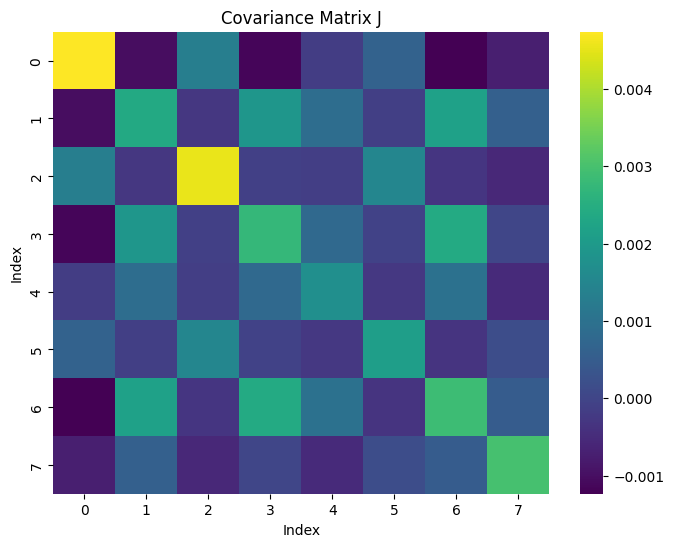

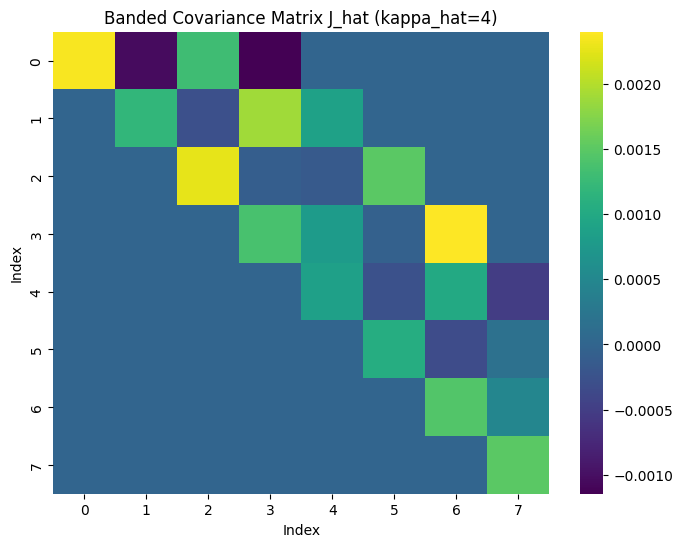

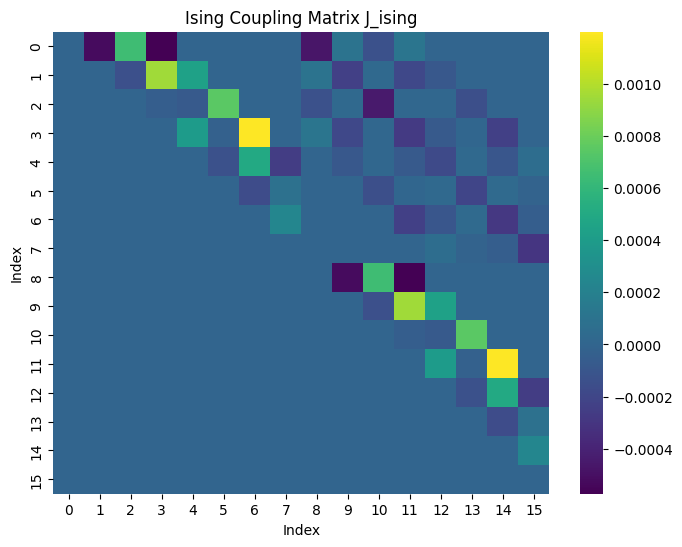

Bopt shape: (8, 2)
X shape: (38, 8)
R_L1 shape: (38, 2)


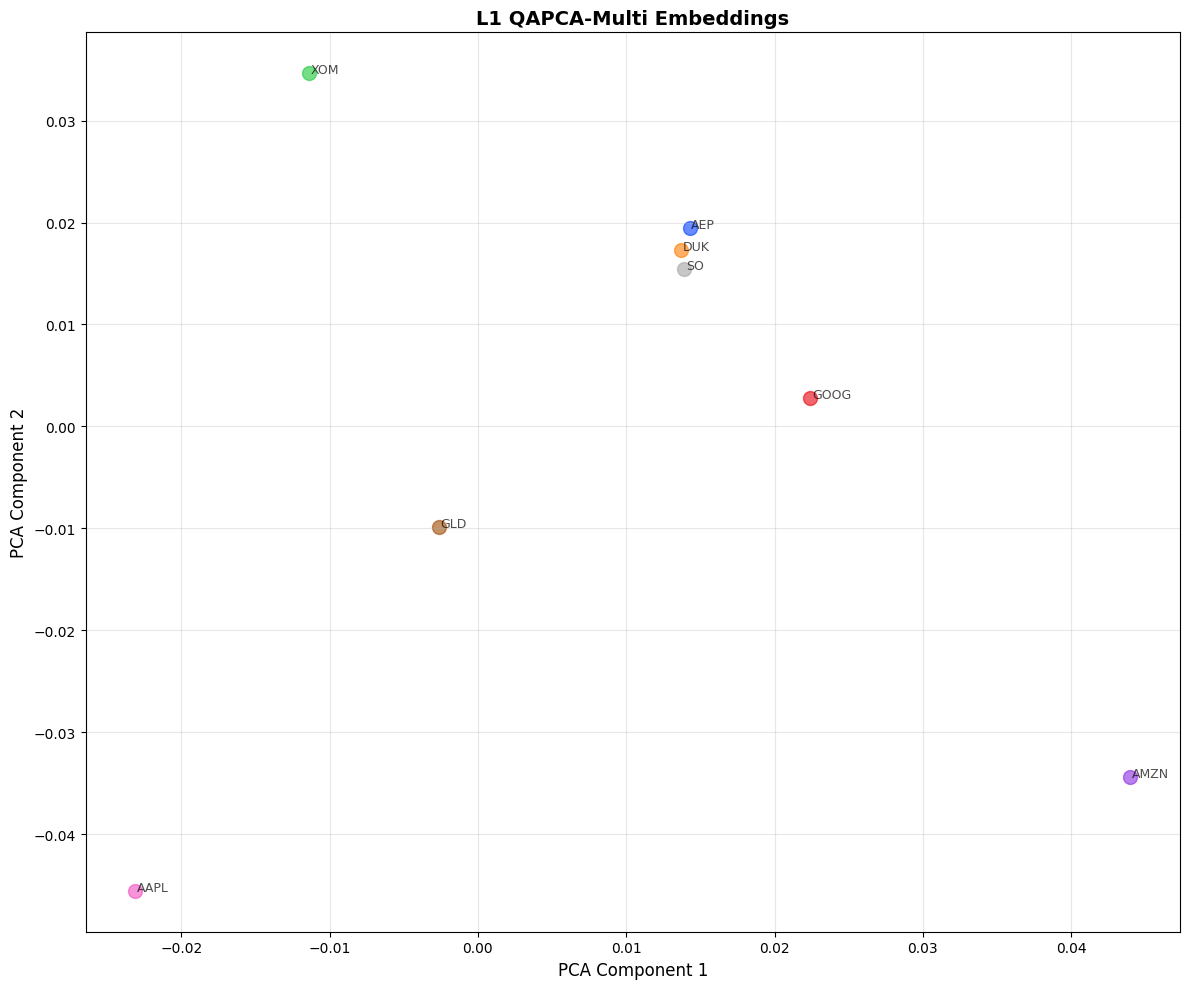

In [44]:
qapca_multi_embeddings_2, _ = do_l1_pca(ticker_data, 2, functools.partial(solve_l1_multi_component_embedded, K=2, eps=0.2, num_reads=100), is_recursive=False)

create_scatterplot(qapca_multi_embeddings_2, tickers, "L1 QAPCA-Multi Embeddings")